In [1]:
%%capture
# Install HermesPy and its dependencies in the current kernel
# When running on Colabs, a restart of the runtime is required afterwards

import sys
!{sys.executable} -m pip install --quiet hermespy

Using Beamformers
===============

This Jupyter notebook provides an in-depth introduction to HermesPy's antenna array definition and beamforming interfaces.
It showcases how to configure MIMO antenna arrays in classic and hybrid configurations, how to specify the antenna element topologies and how to configure custom antenna models within the array.
Furthermore, operating conventional delay and sum beamformers on the ....

Consider a classical fully digitally beamformed transmitting antenna array consisting of a planar grid of $4 \times 4 = 16$ atennna elements located in the x-y plane of a cartesian coordinate system.
From a hardware point of view, this means a dedicated digital-analog converter will feed, over its respective radio-frequency chain, each antenna element, respectively.
Within Hermes, this concept is realised by AntennaPorts, which can be connected to a single antenna element or to multiple antenna elements.

A digital antenna array as assumed above can described in Hermes' API by

In [2]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import speed_of_light

from hermespy.core import AntennaMode, Transformation
from hermespy.simulation import SimulatedIdealAntenna, SimulatedCustomArray

bandwidth, oversampling_factor = 1e7, 4
carrier_frequency = 70e9
wavelength = speed_of_light / carrier_frequency

transmit_antennas = [
    SimulatedIdealAntenna(
        AntennaMode.TX,
        Transformation.From_Translation(np.array([.5 * wavelength * x, .5 * wavelength * y, 0]))
    ) for x, y in product(range(4), range(4))
]

uniform_array = SimulatedCustomArray(transmit_antennas)

which generates an antenna array consisting of ideal istropic antenna elements spaced at half-wavelength intervals, each antenna connected to a single feeding antenna port.
This topology can be visualized by calling

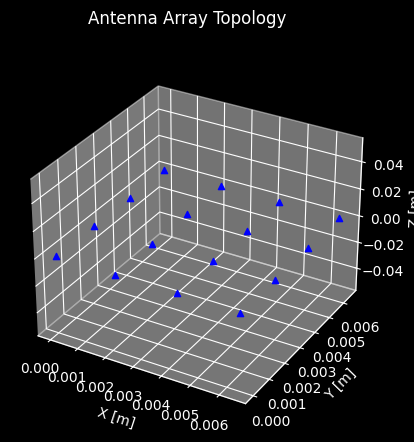

In [3]:
# Visualize the antenna array element positions in the array's local coordinate system
_ = uniform_array.plot_topology()
plt.show()

Of course, we are not limited to uniform linear arrays, but can also define arbitrary antenna element topologies, such as a spiral configurations:

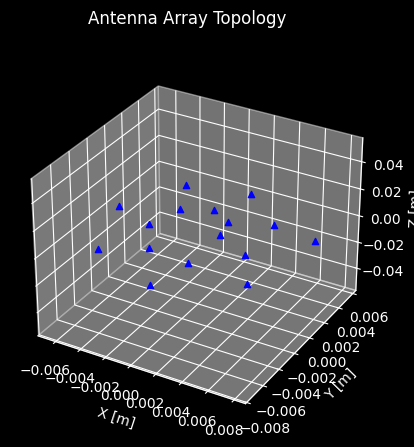

In [4]:
v = .1 * wavelength
w =  200 * wavelength
c = .4 * wavelength

spiral_ports = [
    SimulatedIdealAntenna(
        AntennaMode.TX,
        Transformation.From_Translation([(v*t + c) * np.cos(w * t), (v*t + c) * np.sin(w * t), 0]),
    ) for t in range(16)
]

spiral_array = SimulatedCustomArray(spiral_ports)
_ = spiral_array.plot_topology()
plt.show()

Let's investigate how the antenna array's radiation pattern changes with respect to the assumed antenna element topology.
For this, we will initialize a new simulation environment and assign our custom antenna array to a device representing a transmitting base station / access point:

In [ ]:
from scipy.constants import pi

from hermespy.beamforming import BeamformingTransmitter, ConventionalBeamformer, SphericalFocus
from hermespy.core import ConsoleMode, Signal
from hermespy.simulation import Simulation

# Initialize a new simulation
simulation = Simulation(console_mode=ConsoleMode.SILENT, seed=42)

# Create a new device and assign it the antenna array
base_station_device = simulation.new_device(
    antennas=uniform_array,
    carrier_frequency=carrier_frequency,
    bandwidth=bandwidth,
    oversampling_factor=oversampling_factor,
    pose=Transformation.From_Translation(np.array([0, 0, 0])),
)

To probe the charcteristics, we assume a conventional delay and sum beamformer transmitting a sinusoidal probing signal over the antenna array.


In [6]:
# Configure the device to transmit a beamformed sinusoidal probing signal
beamformer = ConventionalBeamformer()
sinusoid = Signal.Create(np.outer(np.ones(1), np.exp(2j * pi * .25 * np.arange(100) / bandwidth)), bandwidth * oversampling_factor)
base_station_transmitter = BeamformingTransmitter(sinusoid, beamformer)
base_station_device.transmitters.add(base_station_transmitter)

We may now visualize the array's radiation pattern by specifiying the beamformer's transmitting focus point and calling the plot_pattern method.

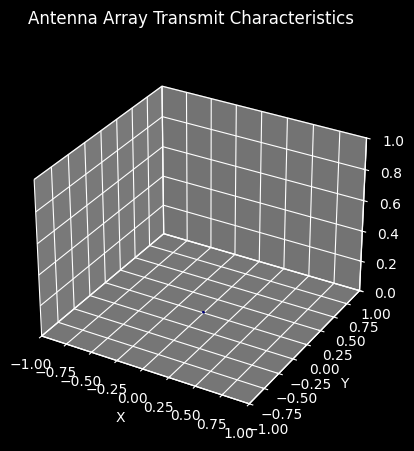

In [7]:
# Focus spherical coordinates -.75pi, .3pi
beamformer.transmit_focus = SphericalFocus(-.75 * pi, .3 * pi)
_ = uniform_array.plot_pattern(carrier_frequency, beamformer)
plt.show()

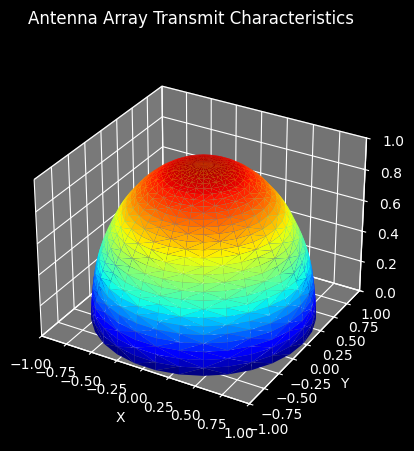

In [8]:
# Focus spherical coordinates 0, 0, i.e. along the z-axis
beamformer.transmit_focus = SphericalFocus(0, 0)
_ = uniform_array.plot_pattern(carrier_frequency, beamformer)
plt.show()

Let's extend our simulation to evaluate our custom base station's performance in a urban communication scenario.
For this purpose, we will add a device representing user equipment to be illuminated by the base station, located somewhere in the positive x-y-z quadrant of the base station's local cartesian coordinate system.

In [9]:
from hermespy.core import SignalReceiver

# Create a new simulated device representing user equipment
user_equipment_device = simulation.new_device(
    carrier_frequency=carrier_frequency,
    bandwidth=bandwidth,
    oversampling_factor=oversampling_factor,
    pose=Transformation.From_Translation(np.array([50., 50., 100.])),
)

# Configure the user equipment to simply record 120 samples of any signal impinging on it
user_equipment_receiver = SignalReceiver(2000, expected_power=sinusoid.power[0])
user_equipment_device.receivers.add(user_equipment_receiver)

We can instruct the base station to always steer its main lobe towards the user equipment by changing the beamformer's transmit focus point to a device focus object referencing the user equipment:

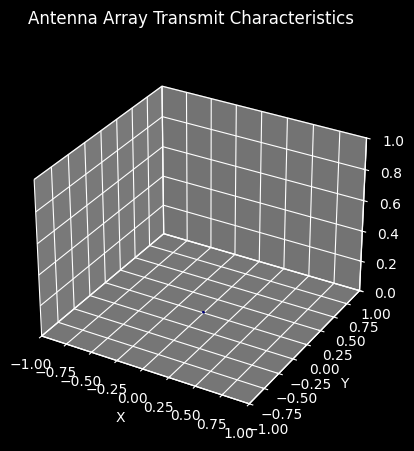

In [10]:
from hermespy.simulation import DeviceFocus

# Focus the base station's main lobe on the user equipment
beamformer.transmit_focus = DeviceFocus(user_equipment_device)

# Visualize the beam pattern
_ = uniform_array.plot_pattern(carrier_frequency, beamformer)
plt.show()

The propagation characeristics between base station and terminal are to be modeled by a basic spatial channel considering only direct line of sight connections between devices and their respective time-of-flight delays:

In [11]:
from hermespy.channel import SpatialDelayChannel

# Configure a basic spatial channel between base station and user equipment
simulation.set_channel(
    base_station_device,
    user_equipment_device,
    SpatialDelayChannel(model_propagation_loss=False),
)

All of the individual parts of a physical layer simulation within Hermes are now in place.
Before launching a full-scale Monte-Carlo campaign which might run for several hours we can generate single drops in order to investigate whether the signals received by the user equipment are in line with our expectations.

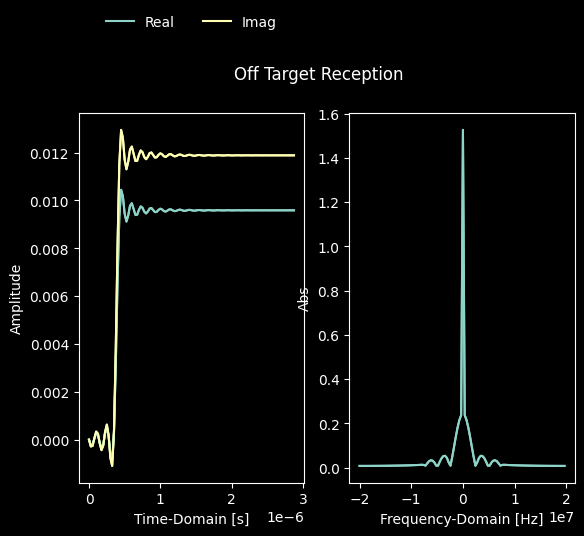

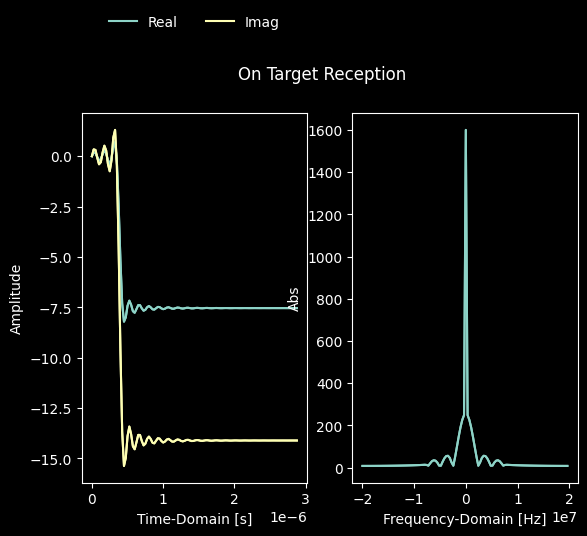

In [12]:
off_target_focus = SphericalFocus(-.75 * pi, .3 * pi)
on_target_focus = DeviceFocus(user_equipment_device)

beamformer.transmit_focus = off_target_focus
off_focus_drop = simulation.drop()
off_focus_drop.device_receptions[1].baseband_signal.plot(title='Off Target Reception')

beamformer.transmit_focus = on_target_focus
on_focus_drop = simulation.drop()
on_focus_drop.device_receptions[1].baseband_signal.plot(title='On Target Reception')

plt.show()

The signal plots visualizing the user equipment's reception confirm that the base station beamforming works as intended.
When focusing the beamformer away from the base station, the received signal power drops significantly when compared to the case where the beamformer is focused towards the user equipment.

These plots only represent a single data point of an evaluation. We can instruct HermesPy to conduct a simulation campaign evaluating the expected received signal power at the user equipment by adding the respective evaluator to the simulation.

In [13]:
from hermespy.core import ReceivePowerEvaluator

# Add a signal power evaluation to the simulation
simulation.add_evaluator(ReceivePowerEvaluator(
    user_equipment_receiver,
    plot_surface=False,
))

The simulation can be instructed to dynamically switch the beamforming focus from our on-target angles to our off-target angles and collect received power estimates for each configuration by adding a simulation grid dimension configuring the beamformer's respective attribute:

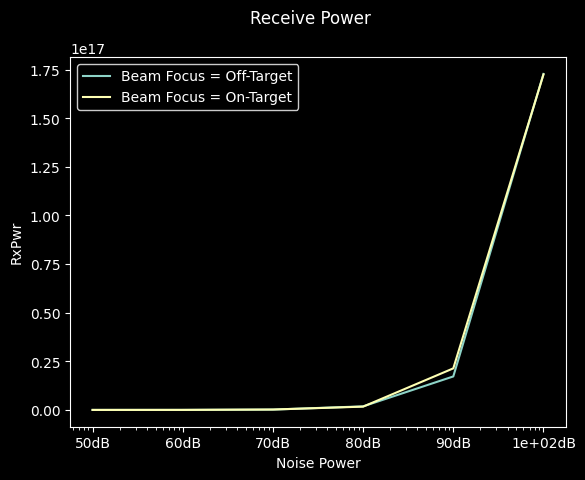

In [14]:
import matplotlib.pyplot as plt
from hermespy.core import dB, SamplePoint

# Configure a simulation dimension varying the receive SNR
snr_dimension = simulation.new_dimension(
    'noise_level',
    dB([100, 90, 80, 70, 60, 50]),
    user_equipment_device,
)

# Configure a simulation dimension switching the beam focus
focus_dimension = simulation.new_dimension(
    'transmit_focus',
    [
        SamplePoint(off_target_focus, 'Off-Target'),
        SamplePoint(on_target_focus, 'On-Target'),
    ],
    beamformer,
    title='Beam Focus',
)

# Collect 100 drops per parameter combination
simulation.num_drops = 100

# Run the simulation campaign and plot the results
result = simulation.run()
result.plot()
plt.show()

As expected, we confirmed that our beamformer will increase the power received at the user equipment by three orders of magnitude when focusing the equipment when compared to the selected off-focus angle.